In [0]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df=pd.read_csv("/content/drive/My Drive/DWDM/DWDM flight/raw-flight-data.csv")
print(df.head())
df.shape

   DayofMonth  DayOfWeek Carrier  OriginAirportID  DestAirportID  DepDelay  \
0          19          5      DL            11433          13303      -3.0   
1          19          5      DL            14869          12478       0.0   
2          19          5      DL            14057          14869      -4.0   
3          19          5      DL            15016          11433      28.0   
4          19          5      DL            11193          12892      -6.0   

   ArrDelay  
0       1.0  
1      -8.0  
2     -15.0  
3      24.0  
4     -11.0  


(2719418, 7)

Terdapat 2719418 data dan 7 kolom

In [0]:
pd.options.mode.chained_assignment = None

missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['(%) missing']=(missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('(%) missing').reset_index(drop = True)


,variable,missing values,(%) missing
0,DayofMonth,0,0.000000
1,DayOfWeek,0,0.000000
2,Carrier,0,0.000000
3,OriginAirportID,0,0.000000
4,DestAirportID,0,0.000000
5,DepDelay,27444,1.009187
6,ArrDelay,29033,1.067618


Saat memilih teknik, harus dilihat terlebih dahulu datasetnya. Jika jumlah row yang memiliki missing value banyak, maka lebih baik mengisi missing value tersebut menggunakan mean. Namun jika jumlah row yang memiliki missing value sedikit, maka lebih baik menghapus missing values tersebutSaat memilih teknik, harus dilihat terlebih dahulu datasetnya. Jika jumlah row yang memiliki missing value banyak, maka lebih baik mengisi missing value tersebut menggunakan mean. Namun jika jumlah row yang memiliki missing value sedikit, maka lebih baik menghapus missing values tersebut

dari data diatas filling factornya masih bagus > 98%, sehingga dalam dataset ini kami memilih melakukan Delete Missing Values

In [0]:
df_cleanNA = df.dropna(inplace=False)
print("Jumlah data yang memiliki missing value : ",(len(df.index))-(len(df_cleanNA)))
print("Jumlah data setelah dihapus NA : ", len(df_cleanNA))
print("Jumlah data duplicate : ",df_cleanNA.duplicated().sum() )
df_cleanNA.drop_duplicates(subset=None, keep='first', inplace=True)
print("Jumlah setelah data duplicate dihapus : ",len(df_cleanNA))

Jumlah data yang memiliki missing value :  29033
Jumlah data setelah dihapus NA :  2690385
Jumlah data duplicate :  17200
Jumlah setelah data duplicate dihapus :  2673185


In [0]:

global_stats = df['ArrDelay'].groupby(df['Carrier']).describe().sort_values('count', ascending=False)
global_stats


#df['amount'].groupby(train_x['state1']).describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Carrier,,,,,,,,
WN,576220.0,8.273722,31.307602,-58.0,-7.0,0.0,13.0,614.0
DL,384325.0,2.699999,38.407233,-71.0,-13.0,-6.0,5.0,1166.0
AA,288118.0,7.120170,45.708878,-75.0,-13.0,-4.0,11.0,1835.0
UA,285207.0,5.138061,41.334290,-75.0,-15.0,-6.0,10.0,779.0
US,233045.0,3.871939,30.927539,-71.0,-11.0,-3.0,8.0,848.0
OO,158424.0,6.367287,34.002914,-61.0,-10.0,-3.0,9.0,774.0
EV,153808.0,10.457492,45.791934,-62.0,-14.0,-4.0,14.0,812.0
B6,121736.0,9.618305,42.656864,-71.0,-13.0,-3.0,14.0,510.0
MQ,109307.0,14.189485,51.250619,-69.0,-11.0,-1.0,19.0,1237.0


In [0]:
pd.options.mode.chained_assignment = None

missing_df = df_cleanNA.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['(%) missing']=(missing_df['missing values'])/df_cleanNA.shape[0]*100
missing_df.sort_values('(%) missing').reset_index(drop = True)


,variable,missing values,(%) missing
0,DayofMonth,0,0.0
1,DayOfWeek,0,0.0
2,Carrier,0,0.0
3,OriginAirportID,0,0.0
4,DestAirportID,0,0.0
5,DepDelay,0,0.0
6,ArrDelay,0,0.0


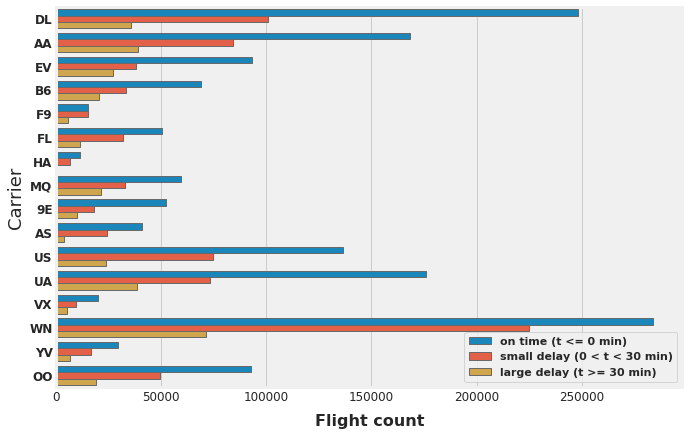

In [0]:
#_____________________________________________
# Function that define how delays are grouped
#labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
delay_type = lambda x:((0,1)[x >= 0],2)[x >= 30]
df['DELAY_LEVEL'] = df['ArrDelay'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="Carrier", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [s for s in  global_stats.index]

#ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(True)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('small delay (0 < t < 30 min)')
L.get_texts()[2].set_text('large delay (t >= 30 min)')
plt.show()

Statistik dari Maskapai diurutkan berdasarkan penerbangan terbanyak

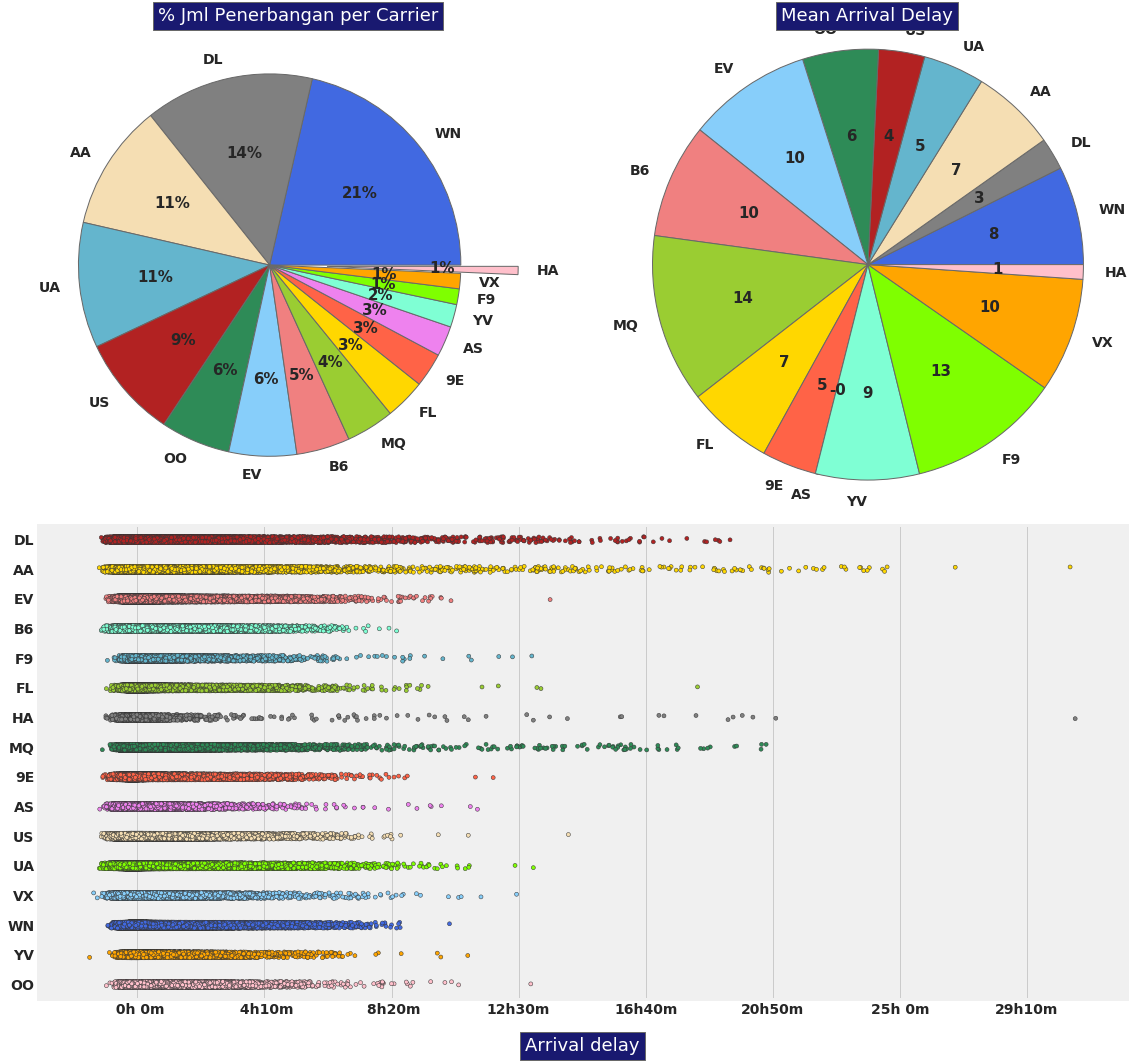

In [0]:
font = {'family' : 'DejaVu Sans', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches

df2 = df.loc[:, ['Carrier', 'ArrDelay']]
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse','orange','pink']
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(global_stats['count'].index))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(global_stats['count'].index)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% Jml Penerbangan per Carrier', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)

comp_handler = []
sizes  = global_stats['mean'].values
#sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(global_stats['count'].index))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(global_stats['count'].index)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean Arrival Delay', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue','orange','pink']

ax3 = sns.stripplot(y="Carrier", x="ArrDelay", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Arrival delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

plt.tight_layout(w_pad=3) 

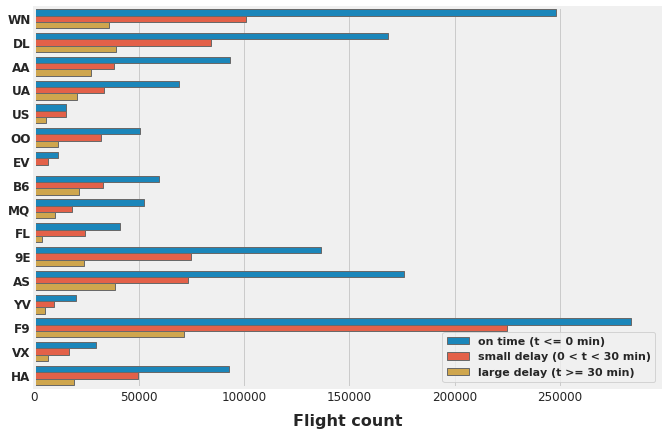

In [0]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x >= 0],2)[x >= 30]
df['DELAY_LEVEL'] = df['ArrDelay'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="Carrier", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
#labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('small delay (0 < t < 30 min)')
L.get_texts()[2].set_text('large delay (t >= 30 min)')
plt.show()

In [0]:
dow_stats = df['ArrDelay'].groupby(df['DayOfWeek']).describe().sort_values('count', ascending=False)
dow_stats

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,406528.0,7.042428,38.766208,-79.0,-11.0,-3.0,11.0,1609.0
4,402783.0,10.806871,42.628469,-94.0,-10.0,-1.0,15.0,1423.0
3,400342.0,7.214399,39.984954,-71.0,-11.0,-3.0,10.0,1440.0
2,396246.0,4.334737,36.187186,-86.0,-12.0,-4.0,8.0,1835.0
5,394486.0,8.702626,40.080200,-70.0,-11.0,-2.0,13.0,1845.0
7,371818.0,5.208051,36.872728,-69.0,-12.0,-4.0,9.0,1466.0
6,318182.0,2.095681,33.606469,-74.0,-13.0,-5.0,6.0,1385.0


NameError: ignored

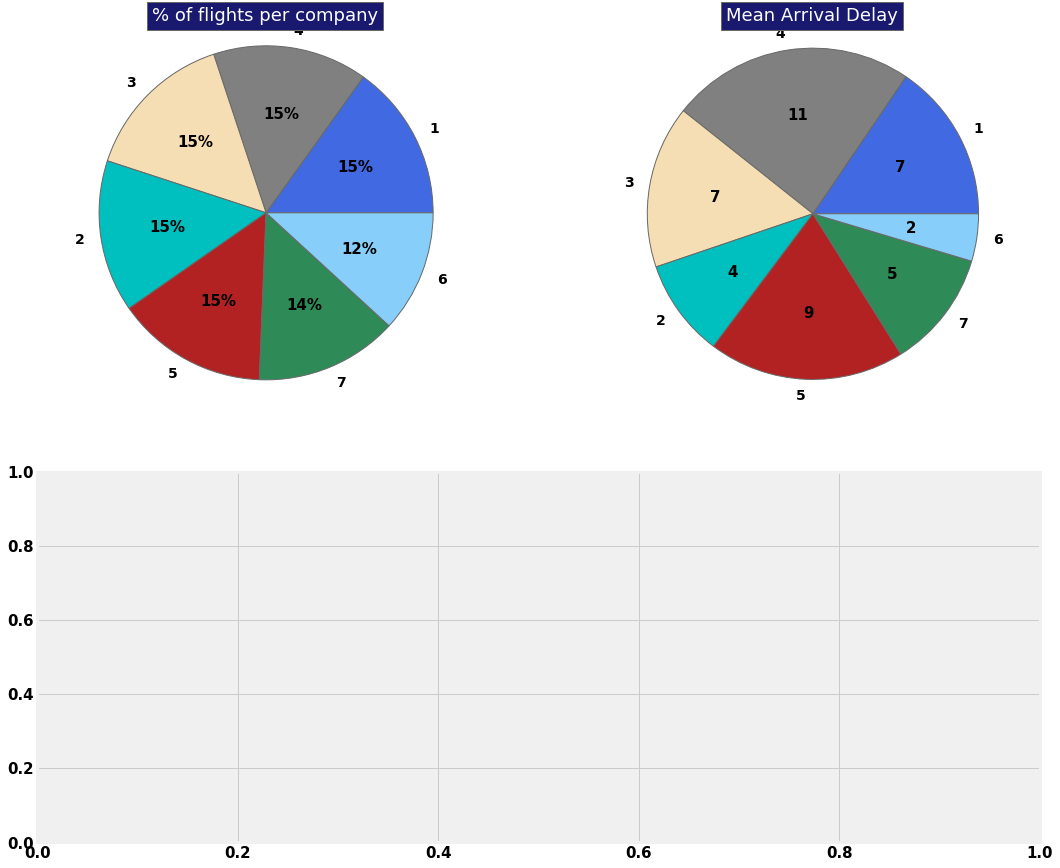

In [0]:
font = {'family' : 'DejaVu Sans', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches

df2 = df.loc[:, ['DayOfWeek', 'ArrDelay']]
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue']
#          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse','orange','pink']
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  dow_stats.index]
sizes  = dow_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(dow_stats['count'].index))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(dow_stats['count'].index)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)

comp_handler = []
sizes  = dow_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(dow_stats['count'].index))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(dow_stats['count'].index)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean Arrival Delay', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'yellowgreen', 'grey',
          'seagreen']


sns.boxplot('Origin','NASDelay', data=df,ax=ax[1])

plt.tight_layout(w_pad=3) 

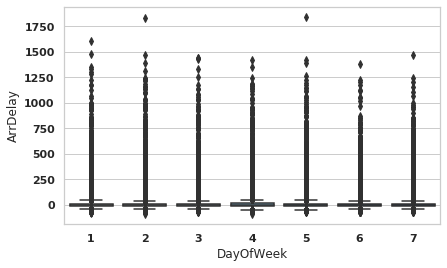

In [0]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="DayOfWeek", y="ArrDelay", data=df, palette="Blues")



In [0]:
df['ArrDelay'].groupby(df['DayOfWeek']).describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,406528.0,7.042428,38.766208,-79.0,-11.0,-3.0,11.0,1609.0
4,402783.0,10.806871,42.628469,-94.0,-10.0,-1.0,15.0,1423.0
3,400342.0,7.214399,39.984954,-71.0,-11.0,-3.0,10.0,1440.0
2,396246.0,4.334737,36.187186,-86.0,-12.0,-4.0,8.0,1835.0
5,394486.0,8.702626,40.080200,-70.0,-11.0,-2.0,13.0,1845.0
7,371818.0,5.208051,36.872728,-69.0,-12.0,-4.0,9.0,1466.0
6,318182.0,2.095681,33.606469,-74.0,-13.0,-5.0,6.0,1385.0


In [0]:
font = {'family' : 'DejaVu Sans', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches

df2 = df.loc[:, ['Carrier', 'ArrDelay']]
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse','orange','pink']
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(global_stats['count'].index))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(global_stats['count'].index)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)

comp_handler = []
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(global_stats['count'].index))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(global_stats['count'].index)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue','orange','pink']

ax3 = sns.stripplot(y="Carrier", x="ArrDelay", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Arrival delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

plt.tight_layout(w_pad=3) 

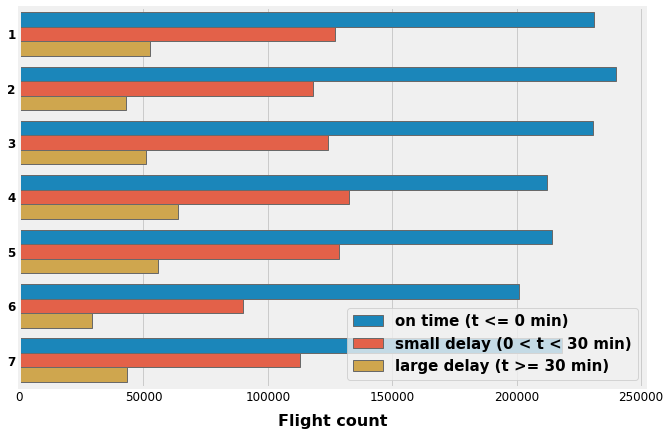

In [0]:

global_stats = df['ArrDelay'].groupby(df['DayOfWeek']).apply(get_stats).unstack()
#global_stats = global_stats.sort_values('count')
labels = [s for s in  global_stats.index]
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x >= 0],2)[x >= 30]
df['DELAY_LEVEL'] = df['ArrDelay'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="DayOfWeek", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
#labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t <= 0 min)')
L.get_texts()[1].set_text('small delay (0 < t < 30 min)')
L.get_texts()[2].set_text('large delay (t >= 30 min)')
plt.show()

In [0]:
dataDep = df
dataDep['DepStatus'] = "notyet"
dataDep.loc[dataDep['DepDelay']<0, 'DepStatus'] = "Cepat"
dataDep.loc[dataDep['DepDelay']>0, 'DepStatus'] = "Lambat"
dataDep.loc[dataDep['DepDelay']==0, 'DepStatus'] = "Ontime"

#filter data yang sampai terlambat berdasarkan data departure cepat,lambat sama ontime
filterDataTelat = df.loc[(df["ArrDelay"]>0)].groupby(['DepStatus']).count()
#filer data yang ontime
filterDataOntime = df.loc[(df["ArrDelay"]==0)].groupby(['DepStatus']).count()
dataDepOntimeDanArrivalTelat = df.loc[(df["ArrDelay"]<0) & (df["DepStatus"]=='Lambat')]
#filter data yang cepat
filterDataCepat = df.loc[(df["ArrDelay"]<0)].groupby(['DepStatus']).count()
semuaData = df.groupby(['DepStatus']).count().sort_values(['DepDelay'], ascending=False)
ratioTelat = (filterDataTelat/semuaData)*100
ratioCepat = (filterDataCepat/semuaData)*100
ratioOntime= (filterDataOntime/semuaData)*100
dataDelay = pd.DataFrame(ratioTelat['DayOfWeek'])
dataOntime = pd.DataFrame(ratioOntime['DayOfWeek'])
dataNotDelay = pd.DataFrame(ratioCepat['DayOfWeek'])
result = pd.concat([dataDelay,dataNotDelay,dataOntime], axis=1)
label = ratioTelat.index
ratioTelat = np.asarray(ratioTelat['DayOfWeek'])
ratioOntime = np.asarray(ratioOntime['DayOfWeek'])
ratioCepat = np.asarray(ratioCepat['DayOfWeek'])


In [0]:
dataDepOntimeDanArrivalTelat = df.loc[(df["ArrDelay"]>0) & (df["DepStatus"]=='Cepat')]
dataDepOntimeDanArrivalCepat = df.loc[(df["ArrDelay"]<0) & (df["DepStatus"]=='Cepat')]
dataDepOntimeDanArrivalOntime = df.loc[(df["ArrDelay"]==0) & (df["DepStatus"]=='Cepat')]
semuacepat = df.loc[(df["DepStatus"]=='Cepat')]
semualambat = df.loc[(df["DepStatus"]=='Lambat')]
semuaontime = df.loc[(df["DepStatus"]=='Ontime')]


print(len(dataDepOntimeDanArrivalTelat))
print(len(dataDepOntimeDanArrivalCepat))
print(len(dataDepOntimeDanArrivalOntime))
nil = len(dataDepOntimeDanArrivalTelat)+len(dataDepOntimeDanArrivalCepat)+len(dataDepOntimeDanArrivalOntime)
print(nil)
print(len(semuacepat)+len(semualambat)+len(semuaontime))
print(len(dataDepOntimeDanArrivalOntime)/len(semuacepat)*100)

244738
1125127
32960
1402825
2691974
2.348689123631119


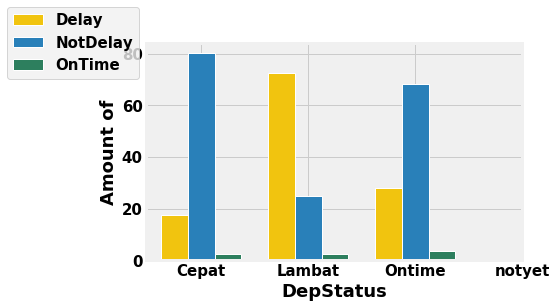

In [0]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25 
# set height of bar
bars1 = ratioTelat
bars2 = ratioCepat
bars3 = ratioOntime

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2] 
# Make the plot
plt.bar(r1, bars1, color='#f1c40f', width=barWidth, edgecolor='white', label='Delay')
plt.bar(r2, bars2, color='#2980b9', width=barWidth, edgecolor='white', label='NotDelay')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='OnTime')
# Add xticks on the middle of the group bars
plt.xlabel('DepStatus', fontweight='bold')
plt.ylabel('Amount of', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], label)
plt.legend(bbox_to_anchor=(0, 1), loc='center right', ncol=1)
plt.show()